<!-- dom:TITLE: Week 3 January 18-22: Building a Variational Monte Carlo program  -->
# Week 3 January 18-22: Building a Variational Monte Carlo program 
<!-- dom:AUTHOR: Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no at Department of Physics and Center fo Computing in Science Education, University of Oslo, Oslo, Norway & Department of Physics and Astronomy and Facility for Rare Ion Beams, Michigan State University, East Lansing, Michigan, USA -->
<!-- Author: -->  
**Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no**, Department of Physics and Center fo Computing in Science Education, University of Oslo, Oslo, Norway and Department of Physics and Astronomy and Facility for Rare Ion Beams, Michigan State University, East Lansing, Michigan, USA

Date: **Jan 21, 2021**

Copyright 1999-2021, Morten Hjorth-Jensen  Email morten.hjorth-jensen@fys.uio.no. Released under CC Attribution-NonCommercial 4.0 license




## Overview of week 3
**Topics.**

* Variational Monte Carlo methods, Metropolis Algorithm, statistics and Markov Chain theory

* How to structure the VMC code




## Setting up a VMC code

In setting up a C++ code for variational Monte Carlo calculations, we will use an excellent framework developed by a former Computational Physics student, Morten Ledum, now PhD student at the Hylleraas center for Quantum Chemistry.
The GitHub repository is at <https://github.com/mortele/variational-monte-carlo-fys4411>.

We will discuss this both in our forthcoming lectures and during our lab sessions.



## Introduction

### Structure and Aims

These notebooks serve the aim of linking traditional variational Monte
Carlo VMC calculations methods with recent progress on solving
many-particle problems using Machine Learning algorithms.



### This notebook

In this notebook the aim is to give you an introduction as well as an
understanding of the basic elements that are needed in order to
develop a professional variational Monte Carlo code. We will focus on
a simple system of two particles in an oscillator trap (or
alternatively two fermions moving in a Coulombic potential). The particles can
interact via a repulsive or an attrative force.  It is thus similar to the system described in project 1.

The advantage of these systems is that for two particles (boson or
fermions) we have analytical solutions for the eigenpairs of the
non-interacting case. Furthermore, for a two- or three-dimensional
system of two electrons moving in a harmonic oscillator trap, we have
[analytical solutions for the interacting case as well](https://iopscience.iop.org/article/10.1088/0305-4470/27/3/040/meta).  

Having analytical eigenpairs is an invaluable feature that allows us 
to assess the physical relevance of the trial wave functions, be
these either from a standard VMC procedure, from Boltzmann Machines or
from Shadow Wave functions.

In this notebook we start with the basics of a VMC calculation and
introduce concepts like Markov Chain Monte Carlo methods and the
Metropolis algorithm, importance sampling and Metropolis-Hastings
algorithm, resampling methods to obtain better estimates of the
statistical errors and minimization of the expectation values of the
energy and the variance. The latter is done in order to obtain the
best possible variational parameters. Furthermore it will define the
so-called **cost** function, a commonly encountered quantity in Machine
Learning algorithms. Minimizing the latter is the one which leads to
the determination of the optimal parameters in basically all Machine Learning algorithms.
This is a possible topic for project 2.


Topics like Markov Chain Monte Carlo and various resampling techniques
are also central to Machine Learning methods. Presenting them in the
context of VMC approaches leads hopefully to an easier starting point
for the understanding of these methods for those of you who will do the machine lerning variant of project 2.


## Basic Quantum Monte Carlo

We start with the variational principle.
Given a hamiltonian $H$ and a trial wave function $\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})$, the variational principle states that the expectation value of $\cal{E}[H]$, defined through

$$
\cal {E}[H] =
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})},
$$

is an upper bound to the ground state energy $E_0$ of the hamiltonian $H$, that is

$$
E_0 \le {\cal E}[H].
$$

In general, the integrals involved in the calculation of various
expectation values are multi-dimensional ones. Traditional integration
methods such as Gauss-Legendre quadrature will not be adequate for say the
computation of the energy of a many-body system.

Here we have defined the vector $\boldsymbol{R} = [\boldsymbol{r}_1,\boldsymbol{r}_2,\dots,\boldsymbol{r}_n]$  as an array that contains the positions of all particles $n$ while the vector $\boldsymbol{\alpha} = [\alpha_1,\alpha_2,\dots,\alpha_m]$ contains the variational parameters of the model, $m$ in total. 

The trial wave function can be expanded in the eigenstates $\Psi_i(\boldsymbol{R})$ 
of the hamiltonian since they form a complete set, viz.,

$$
\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})=\sum_i a_i\Psi_i(\boldsymbol{R}),
$$

and assuming that the set of eigenfunctions are normalized, one obtains

$$
\frac{\sum_{nm}a^*_ma_n \int d\boldsymbol{R}\Psi^{\ast}_m(\boldsymbol{R})H(\boldsymbol{R})\Psi_n(\boldsymbol{R})}
        {\sum_{nm}a^*_ma_n \int d\boldsymbol{R}\Psi^{\ast}_m(\boldsymbol{R})\Psi_n(\boldsymbol{R})} =\frac{\sum_{n}a^2_n E_n}
        {\sum_{n}a^2_n} \ge E_0,
$$

where we used that $H(\boldsymbol{R})\Psi_n(\boldsymbol{R})=E_n\Psi_n(\boldsymbol{R})$.
In general, the integrals involved in the calculation of various  expectation
values  are multi-dimensional ones. 
The variational principle yields the lowest energy of states with a  given symmetry.

In most cases, a wave function has only small values in large parts of 
configuration space, and a straightforward procedure which uses
homogenously distributed random points in configuration space 
will most likely lead to poor results. This may suggest that some kind
of importance sampling combined with e.g., the Metropolis algorithm 
may be  a more efficient way of obtaining the ground state energy.
The hope is then that those regions of configurations space where
the wave function assumes appreciable values are sampled more 
efficiently. 

The tedious part in a VMC calculation is the search for the variational
minimum. A good knowledge of the system is required in order to carry out
reasonable VMC calculations. This is not always the case, 
and often VMC calculations 
serve rather as the starting
point for so-called diffusion Monte Carlo calculations (DMC). Diffusion Monte Carlo  is a way of
solving exactly the many-body Schroedinger equation by means of 
a stochastic procedure. A good guess on the binding energy
and its wave function is however necessary. 
A carefully performed VMC calculation can aid in this context. 


The basic procedure of a Variational Monte Carlo calculations consists thus of 

1. Construct first a trial wave function $\psi_T(\boldsymbol{R};\boldsymbol{\alpha})$,  for a many-body system consisting of $n$ particles located at positions  $\boldsymbol{R}=(\boldsymbol{R}_1,\dots ,\boldsymbol{R}_n)$. The trial wave function depends on $\alpha$ variational parameters $\boldsymbol{\alpha}=(\alpha_1,\dots ,\alpha_M)$.

2. Then we evaluate the expectation value of the hamiltonian $H$

$$
\overline{E}[\boldsymbol{\alpha}]=\frac{\int d\boldsymbol{R}\Psi^{\ast}_{T}(\boldsymbol{R},\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_{T}(\boldsymbol{R},\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_{T}(\boldsymbol{R},\boldsymbol{\alpha})\Psi_{T}(\boldsymbol{R},\boldsymbol{\alpha})}.
$$

1. Thereafter we vary $\boldsymbol{\alpha}$ according to some minimization algorithm and return eventually to the first step if we are not satisfied with the results.

Here we have used the notation $\overline{E}$ to label the expectation value of the energy. 

### Linking with standard statistical expressions for expectation values

In order to bring in the Monte Carlo machinery, we define first a likelihood distribution, or probability density distribution (PDF). Using our ansatz for the trial wave function $\psi_T(\boldsymbol{R};\boldsymbol{\alpha})$ we define a PDF

$$
P(\boldsymbol{R})= \frac{\left|\psi_T(\boldsymbol{R};\boldsymbol{\alpha})\right|^2}{\int \left|\psi_T(\boldsymbol{R};\boldsymbol{\alpha})\right|^2d\boldsymbol{R}}.
$$

This is our model for  probability distribution function.
The approximation to the expectation value of the Hamiltonian is now

$$
\overline{E}[\boldsymbol{\alpha}] = 
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})H(\boldsymbol{R})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R};\boldsymbol{\alpha})\Psi_T(\boldsymbol{R};\boldsymbol{\alpha})}.
$$

We define a new quantity

<!-- Equation labels as ordinary links -->
<div id="eq:locale1"></div>

$$
E_L(\boldsymbol{R};\boldsymbol{\alpha})=\frac{1}{\psi_T(\boldsymbol{R};\boldsymbol{\alpha})}H\psi_T(\boldsymbol{R};\boldsymbol{\alpha}),
\label{eq:locale1} \tag{1}
$$

called the local energy, which, together with our trial PDF yields a new expression (and which look simlar to the the expressions for moments in statistics)

<!-- Equation labels as ordinary links -->
<div id="eq:vmc1"></div>

$$
\overline{E}[\boldsymbol{\alpha}]=\int P(\boldsymbol{R})E_L(\boldsymbol{R};\boldsymbol{\alpha}) d\boldsymbol{R}\approx \frac{1}{N}\sum_{i=1}^NE_L(\boldsymbol{R_i};\boldsymbol{\alpha})
\label{eq:vmc1} \tag{2}
$$

with $N$ being the number of Monte Carlo samples. The expression on the right hand side follows from Bernoulli's law of large numbers, which states that the sample mean, in the limit $N\rightarrow \infty$ approaches the true mean 

The Algorithm for performing a variational Monte Carlo calculations runs as this

   * Initialisation: Fix the number of Monte Carlo steps. Choose an initial $\boldsymbol{R}$ and variational parameters $\alpha$ and calculate $\left|\psi_T^{\alpha}(\boldsymbol{R})\right|^2$. 

   * Initialise the energy and the variance and start the Monte Carlo calculation.

      * Calculate  a trial position  $\boldsymbol{R}_p=\boldsymbol{R}+r*step$ where $r$ is a random variable $r \in [0,1]$.

      * Metropolis algorithm to accept or reject this move  $w = P(\boldsymbol{R}_p)/P(\boldsymbol{R})$.

      * If the step is accepted, then we set $\boldsymbol{R}=\boldsymbol{R}_p$. 

      * Update averages


   * Finish and compute final averages.

Observe that the jumping in space is governed by the variable *step*. This is called brute-force sampling and is normally replaced by what is called **importance sampling**, discussed in more detail below here. 


### Simple example, the hydrogen atom

The radial Schroedinger equation for the hydrogen atom can be
written as (when we have gotten rid of the first derivative term in the kinetic energy and used $rR(r)=u(r)$)

$$
-\frac{\hbar^2}{2m}\frac{d^2 u(r)}{d r^2}-
\left(\frac{ke^2}{r}-\frac{\hbar^2l(l+1)}{2mr^2}\right)u(r)=Eu(r).
$$

We will specialize to the case with $l=0$ and end up with

$$
-\frac{\hbar^2}{2m}\frac{d^2 u(r)}{d r^2}-
\left(\frac{ke^2}{r}\right)u(r)=Eu(r).
$$

Then we introduce a dimensionless variable $\rho=r/a$ where $a$ is a constant with dimension length.
Multiplying with $ma^2/\hbar^2$ we can rewrite our equations as

$$
-\frac{1}{2}\frac{d^2 u(\rho)}{d \rho^2}-
\frac{ke^2ma}{\hbar^2}\frac{u(\rho)}{\rho}-\lambda u(\rho)=0.
$$

Since $a$ is just a parameter we choose to set

$$
\frac{ke^2ma}{\hbar^2}=1,
$$

which leads to $a=\hbar^2/mke^2$, better known as the Bohr radius with value $0.053$ nm. Scaling the equations this way does not only render our numerical treatment simpler since we avoid carrying with us all physical parameters, but we obtain also a **natural** length scale. We will see this again and again. In our discussions below with a harmonic oscillator trap, the **natural** lentgh scale with be determined by the oscillator frequency, the mass of the particle and $\hbar$. We have also defined a dimensionless 'energy' $\lambda = Ema^2/\hbar^2$. 
With the rescaled quantities, the ground state energy of the hydrogen atom is $1/2$. 
The equation we want to solve is now defined by the Hamiltonian

$$
H=-\frac{1}{2}\frac{d^2 }{d \rho^2}-\frac{1}{\rho}.
$$

As trial wave function we peep now into the analytical solution for
the hydrogen atom and use (with $\alpha$ as a variational parameter)

$$
u_T^{\alpha}(\rho)=\alpha\rho \exp{-(\alpha\rho)}.
$$

Inserting this wave function into the expression for the
local energy $E_L$ gives

$$
E_L(\rho)=-\frac{1}{\rho}-
              \frac{\alpha}{2}\left(\alpha-\frac{2}{\rho}\right).
$$

To have analytical local energies saves us from computing numerically
the second derivative, a feature which often increases our numerical
expenditure with a factor of three or more. Integratng up the local energy (recall to bring back the PDF in the integration) gives  $\overline{E}[\boldsymbol{\alpha}]=\alpha(\alpha/2-1)$. 




### Second example, the harmonic oscillator in one dimension

We present here another well-known example, the harmonic oscillator in
one dimension for one particle. This will also serve the aim of
introducing our next model, namely that of interacting electrons in a
harmonic oscillator trap.

Here as well, we do have analytical solutions and the energy of the
ground state, with $\hbar=1$, is $1/2\omega$, with $\omega$ being the
oscillator frequency. We use the following trial wave function

$$
\psi_T(x;\alpha) = \exp{-(\frac{1}{2}\alpha^2x^2)},
$$

which results in a local energy

$$
\frac{1}{2}\left(\alpha^2+x^2(1-\alpha^4)\right).
$$

We can compare our numerically calculated energies with the exact energy as function of $\alpha$

$$
\overline{E}[\alpha] = \frac{1}{4}\left(\alpha^2+\frac{1}{\alpha^2}\right).
$$

Similarly, with the above ansatz, we can also compute the exact variance which reads

$$
\sigma^2[\alpha]=\frac{1}{4}\left(1+(1-\alpha^4)^2\frac{3}{4\alpha^4}\right)-\overline{E}.
$$

Our code for computing the energy of the ground state of the harmonic oscillator follows here. We start by defining directories where we store various outputs.

In [30]:
# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCHarmonic"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCHarmonic.dat"),'w')

We proceed with the implementation of the Monte Carlo algorithm but list first the ansatz for the wave function and the expression for the local energy

In [31]:
%matplotlib inline

# VMC for the one-dimensional harmonic oscillator
# Brute force Metropolis, no importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
#from numba import jit
from decimal import *
# Trial wave function for the Harmonic oscillator in one dimension
def WaveFunction(r,alpha):
#    return exp(-0.5*alpha*alpha*r*r)
    return exp(-alpha*r*r)
# Local energy  for the Harmonic oscillator in one dimension
def LocalEnergy(r,alpha):
#    return 0.5*r*r*(1-alpha**4) + 0.5*alpha*alpha
     return alpha+0.5*r*r*(1-alpha*alpha*2)

Note that in the Metropolis algorithm there is no need to compute the
trial wave function, mainly since we are just taking the ratio of two
exponentials. It is then from a computational point view, more
convenient to compute the argument from the ratio and then calculate
the exponential. Here we have refrained from this purely of
pedagogical reasons.

In [32]:
# The Monte Carlo sampling with the Metropolis algo
# The jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when the function is called.
#@jit
def MonteCarloSampling():

    NumberMCcycles= 100000
    StepSize = 1.0
    # positions
    PositionOld = 0.0
    PositionNew = 0.0

    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.1
    for ia in range(MaxVariations):
        alpha += .05
        AlphaValues[ia] = alpha
        energy = energy2 = 0.0
        #Initial position
        PositionOld = StepSize * (random() - .5)
        wfold = WaveFunction(PositionOld,alpha)
        #Loop over MC MCcycles
        for MCcycle in range(NumberMCcycles):
            #Trial position 
            PositionNew = PositionOld + StepSize*(random() - .5)
            wfnew = WaveFunction(PositionNew,alpha)
            #Metropolis test to see whether we accept the move
            if random() <= wfnew**2 / wfold**2:
                PositionOld = PositionNew
                wfold = wfnew
            DeltaE = LocalEnergy(PositionOld,alpha)
            energy += DeltaE
            energy2 += DeltaE**2
        #We calculate mean, variance and error
        energy /= NumberMCcycles
        energy2 /= NumberMCcycles
        variance = energy2 - energy**2
        error = sqrt(variance/NumberMCcycles)
        Energies[ia] = energy    
        Variances[ia] = variance    
        outfile.write('%f %f %f %f \n' %(alpha,energy,variance,error))
    return Energies, AlphaValues, Variances

Finally, the results are presented here with the exact energies and variances as well.

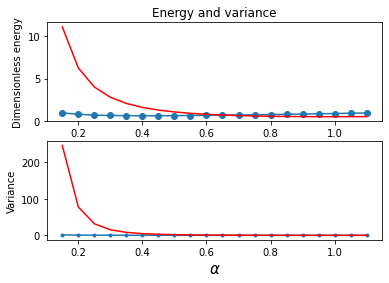

    Alpha    Energy  Exact Energy  Variance  Exact Variance
0    0.15  0.941149     11.116736  1.243299      246.663644
1    0.20  0.792070      6.260000  0.661618       77.875200
2    0.25  0.686198      4.015625  0.380638       31.750488
3    0.30  0.648965      2.800278  0.242972       15.183111
4    0.35  0.620442      2.071441  0.148485        8.081738
5    0.40  0.611472      1.602500  0.088129        4.636013
6    0.45  0.614257      1.285193  0.052863        2.803442
7    0.50  0.629091      1.062500  0.034628        1.757813
8    0.55  0.641561      0.902071  0.016577        1.127465
9    0.60  0.658476      0.784444  0.006923        0.730706
10   0.65  0.679022      0.697341  0.001683        0.472569
11   0.70  0.703600      0.632704  0.000026        0.300629
12   0.75  0.729335      0.585069  0.000883        0.184613
13   0.80  0.757112      0.550625  0.003594        0.106376
14   0.85  0.784465      0.526646  0.008944        0.054712
15   0.90  0.814322      0.511142  0.014

In [33]:
#Here starts the main program with variable declarations
MaxVariations = 20
Energies = np.zeros((MaxVariations))
ExactEnergies = np.zeros((MaxVariations))
ExactVariance = np.zeros((MaxVariations))
Variances = np.zeros((MaxVariations))
AlphaValues = np.zeros(MaxVariations)
(Energies, AlphaValues, Variances) = MonteCarloSampling()
outfile.close()
ExactEnergies = 0.25*(AlphaValues*AlphaValues+1.0/(AlphaValues*AlphaValues))
ExactVariance = 0.25*(1.0+((1.0-AlphaValues**4)**2)*3.0/(4*(AlphaValues**4)))-ExactEnergies*ExactEnergies

#simple subplot
plt.subplot(2, 1, 1)
plt.plot(AlphaValues, Energies, 'o-',AlphaValues, ExactEnergies,'r-')
plt.title('Energy and variance')
plt.ylabel('Dimensionless energy')
plt.subplot(2, 1, 2)
plt.plot(AlphaValues, Variances, '.-',AlphaValues, ExactVariance,'r-')
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Variance')
save_fig("VMCHarmonic")
plt.show()
#nice printout with Pandas
import pandas as pd
from pandas import DataFrame
data ={'Alpha':AlphaValues, 'Energy':Energies,'Exact Energy':ExactEnergies,'Variance':Variances,'Exact Variance':ExactVariance,}
frame = pd.DataFrame(data)
print(frame)

For $\alpha=1$ we have the exact eigenpairs, as can be deduced from the
table here. With $\omega=1$, the exact energy is $1/2$ a.u. with zero
variance, as it should. We see also that our computed variance follows rather well the exact variance.
Increasing the number of Monte Carlo cycles will improve our statistics (try to increase the number of Monte Carlo cycles).

The fact that the variance is exactly equal to zero when $\alpha=1$ is that 
we then have the exact wave function, and the action of the hamiltionan
on the wave function

$$
H\psi = \mathrm{constant}\times \psi,
$$

yields just a constant. The integral which defines various 
expectation values involving moments of the hamiltonian becomes then

$$
\langle H^n \rangle =
   \frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})H^n(\boldsymbol{R})\Psi_T(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}=
\mathrm{constant}\times\frac{\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}
        {\int d\boldsymbol{R}\Psi^{\ast}_T(\boldsymbol{R})\Psi_T(\boldsymbol{R})}=\mathrm{constant}.
$$

**This gives an important information: the exact wave function leads to zero variance!**
As we will see below, many practitioners perform a minimization on both the energy and the variance.



## The Metropolis algorithm

Till now we have not yet discussed the derivation of the Metropolis algorithm. We assume the reader has some familiarity with the mathematics of Markov chains. 

The Metropolis algorithm , see [the original article](http://scitation.aip.org/content/aip/journal/jcp/21/6/10.1063/1.1699114), was invented by Metropolis et. al
and is often simply called the Metropolis algorithm.
It is a method to sample a normalized probability
distribution by a stochastic process. We define $\mathbf{P}_i^{(n)}$ to
be the probability for finding the system in the state $i$ at step $n$.
The algorithm is then

* Sample a possible new state $j$ with some probability $T_{i\rightarrow j}$.

* Accept the new state $j$ with probability $A_{i \rightarrow j}$ and use it as the next sample. With probability $1-A_{i\rightarrow j}$ the move is rejected and the original state $i$ is used again as a sample.

We wish to derive the required properties of $T$ and $A$ such that
$\mathbf{P}_i^{(n\rightarrow \infty)} \rightarrow p_i$ so that starting
from any distribution, the method converges to the correct distribution.
Note that the description here is for a discrete probability distribution.
Replacing probabilities $p_i$ with expressions like $p(x_i)dx_i$ will
take all of these over to the corresponding continuum expressions.

The dynamical equation for $\mathbf{P}_i^{(n)}$ can be written directly from
the description above. The probability of being in the state $i$ at step $n$
is given by the probability of being in any state $j$ at the previous step,
and making an accepted transition to $i$ added to the probability of
being in the state $i$, making a transition to any state $j$ and
rejecting the move:

$$
\mathbf{P}^{(n)}_i = \sum_j \left [
\mathbf{P}^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
+\mathbf{P}^{(n-1)}_iT_{i\rightarrow j}\left ( 1- A_{i\rightarrow j} \right)
\right ] \,.
$$

Since the probability of making some transition must be 1,
$\sum_j T_{i\rightarrow j} = 1$, and the above equation becomes

$$
\mathbf{P}^{(n)}_i = \mathbf{P}^{(n-1)}_i +
 \sum_j \left [
\mathbf{P}^{(n-1)}_jT_{j\rightarrow i} A_{j\rightarrow i} 
-\mathbf{P}^{(n-1)}_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] \,.
$$

For large $n$ we require that $\mathbf{P}^{(n\rightarrow \infty)}_i = p_i$,
the desired probability distribution. Taking this limit, gives the
balance requirement

$$
\sum_j \left [
p_jT_{j\rightarrow i} A_{j\rightarrow i}
-p_iT_{i\rightarrow j}A_{i\rightarrow j}
\right ] = 0 \,.
$$

The balance requirement is very weak. Typically the much stronger detailed
balance requirement is enforced, that is rather than the sum being
set to zero, we set each term separately to zero and use this
to determine the acceptance probabilities. Rearranging, the result is

$$
\frac{ A_{j\rightarrow i}}{A_{i\rightarrow j}}
= \frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}} \,.
$$

The Metropolis choice is to maximize the $A$ values, that is

$$
A_{j \rightarrow i} = \min \left ( 1,
\frac{p_iT_{i\rightarrow j}}{ p_jT_{j\rightarrow i}}\right ).
$$

Other choices are possible, but they all correspond to multilplying
$A_{i\rightarrow j}$ and $A_{j\rightarrow i}$ by the same constant
smaller than unity.\footnote{The penalty function method uses just such
a factor to compensate for $p_i$ that are evaluated stochastically
and are therefore noisy.}

Having chosen the acceptance probabilities, we have guaranteed that
if the  $\mathbf{P}_i^{(n)}$ has equilibrated, that is if it is equal to $p_i$,
it will remain equilibrated. Next we need to find the circumstances for
convergence to equilibrium.

The dynamical equation can be written as

$$
\mathbf{P}^{(n)}_i = \sum_j M_{ij}\mathbf{P}^{(n-1)}_j
$$

with the matrix $M$ given by

$$
M_{ij} = \delta_{ij}\left [ 1 -\sum_k T_{i\rightarrow k} A_{i \rightarrow k}
\right ] + T_{j\rightarrow i} A_{j\rightarrow i} \,.
$$

Summing over $i$ shows that $\sum_i M_{ij} = 1$, and since
$\sum_k T_{i\rightarrow k} = 1$, and $A_{i \rightarrow k} \leq 1$, the
elements of the matrix satisfy $M_{ij} \geq 0$. The matrix $M$ is therefore
a stochastic matrix.


The Metropolis method is simply the power method for computing the
right eigenvector of $M$ with the largest magnitude eigenvalue.
By construction, the correct probability distribution is a right eigenvector
with eigenvalue 1. Therefore, for the Metropolis method to converge
to this result, we must show that $M$ has only one eigenvalue with this
magnitude, and all other eigenvalues are smaller.


## The system: two electrons in a harmonic oscillator trap in two dimensions

The Hamiltonian of the quantum dot is given by

$$
\hat{H} = \hat{H}_0 + \hat{V},
$$

where $\hat{H}_0$ is the many-body HO Hamiltonian, and $\hat{V}$ is the
inter-electron Coulomb interactions. In dimensionless units,

$$
\hat{V}= \sum_{i < j}^N \frac{1}{r_{ij}},
$$

with $r_{ij}=\sqrt{\mathbf{r}_i^2 - \mathbf{r}_j^2}$.

This leads to the  separable Hamiltonian, with the relative motion part given by ($r_{ij}=r$)

$$
\hat{H}_r=-\nabla^2_r + \frac{1}{4}\omega^2r^2+ \frac{1}{r},
$$

plus a standard Harmonic Oscillator problem  for the center-of-mass motion.
This system has analytical solutions in two and three dimensions ([M. Taut 1993 and 1994](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.48.3561)). 

We want to perform  a Variational Monte Carlo calculation of the ground state of two electrons in a quantum dot well with different oscillator energies, assuming total spin $S=0$.
Our trial wave function has the following form

<!-- Equation labels as ordinary links -->
<div id="eq:trial"></div>

$$
\begin{equation}
   \psi_{T}(\boldsymbol{r}_1,\boldsymbol{r}_2) = 
   C\exp{\left(-\alpha_1\omega(r_1^2+r_2^2)/2\right)}
   \exp{\left(\frac{r_{12}}{(1+\alpha_2 r_{12})}\right)}, 
\label{eq:trial} \tag{3}
\end{equation}
$$

where the $\alpha$s represent our variational parameters, two in this case.

Why does the trial function look like this? How did we get there?
**This will be one of our main motivations** for switching to Machine Learning later.


To find an ansatz for the correlated part of the wave function, it is
useful to rewrite the two-particle local energy in terms of the
relative and center-of-mass motion.  
Let us denote the distance
between the two electrons as $r_{12}$. We omit the center-of-mass
motion since we are only interested in the case when $r_{12}
\rightarrow 0$. The contribution from the center-of-mass (CoM)
variable $\boldsymbol{R}_{\mathrm{CoM}}$ gives only a finite contribution.  We
focus only on the terms that are relevant for $r_{12}$ and for three
dimensions. 

The relevant local energy becomes then

$$
\lim_{r_{12} \rightarrow 0}E_L(R)= \frac{1}{{\cal R}_T(r_{12})}\left(2\frac{d^2}{dr_{ij}^2}+\frac{4}{r_{ij}}\frac{d}{dr_{ij}}+\frac{2}{r_{ij}}-\frac{l(l+1)}{r_{ij}^2}+2E \right){\cal R}_T(r_{12})
= 0.
$$

Set $l=0$ and we have the so-called **cusp** condition

$$
\frac{d {\cal R}_T(r_{12})}{dr_{12}} = -\frac{1}{2(l+1)} {\cal R}_T(r_{12})\qquad r_{12}\to 0
$$

The above  results in

$$
{\cal R}_T  \propto \exp{(r_{ij}/2)},
$$

for anti-parallel spins and

$$
{\cal R}_T  \propto \exp{(r_{ij}/4)},
$$

for anti-parallel spins. 
This is the so-called cusp condition for the relative motion, resulting in a minimal requirement
for the correlation part of the wave fuction.
For general systems containing more than say two electrons, we have this
condition for each electron pair $ij$.

### First code attempt for the two-electron case

First, as with the hydrogen case, we declare where to store files.

In [17]:
# Common imports
import os

# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "Results/VMCQdotMetropolis"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

outfile = open(data_path("VMCQdotMetropolis.dat"),'w')

Thereafter we set up the analytical expressions for the wave functions and the local energy

In [18]:
# 2-electron VMC for quantum dot system in two dimensions
# Brute force Metropolis, no importance sampling and no energy minimization
from math import exp, sqrt
from random import random, seed
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys
#from numba import jit


# Trial wave function for the 2-electron quantum dot in two dims
def WaveFunction(r,alpha,beta):
    r1 = r[0,0]**2 + r[0,1]**2
    r2 = r[1,0]**2 + r[1,1]**2
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = r12/(1+beta*r12)
    return exp(-0.5*alpha*(r1+r2)+deno)

# Local energy  for the 2-electron quantum dot in two dims, using analytical local energy
def LocalEnergy(r,alpha,beta):
    
    r1 = (r[0,0]**2 + r[0,1]**2)
    r2 = (r[1,0]**2 + r[1,1]**2)
    r12 = sqrt((r[0,0]-r[1,0])**2 + (r[0,1]-r[1,1])**2)
    deno = 1.0/(1+beta*r12)
    deno2 = deno*deno
    return 0.5*(1-alpha*alpha)*(r1 + r2) +2.0*alpha + 1.0/r12+deno2*(alpha*r12-deno2+2*beta*deno-1.0/r12)

The Monte Carlo sampling without importance sampling is set up here.

In [19]:
# The Monte Carlo sampling with the Metropolis algo
# The jit decorator tells Numba to compile this function.
# The argument types will be inferred by Numba when the function is called.
#@jit
def MonteCarloSampling():

    NumberMCcycles= 10000
    StepSize = 1.0
    # positions
    PositionOld = np.zeros((NumberParticles,Dimension), np.double)
    PositionNew = np.zeros((NumberParticles,Dimension), np.double)

    # seed for rng generator
    seed()
    # start variational parameter
    alpha = 0.9
    for ia in range(MaxVariations):
        alpha += .025
        AlphaValues[ia] = alpha
        beta = 0.2 
        for jb in range(MaxVariations):
            beta += .01
            BetaValues[jb] = beta
            energy = energy2 = 0.0
            DeltaE = 0.0
            #Initial position
            for i in range(NumberParticles):
                for j in range(Dimension):
                    PositionOld[i,j] = StepSize * (random() - .5)
            wfold = WaveFunction(PositionOld,alpha,beta)

            #Loop over MC MCcycles
            for MCcycle in range(NumberMCcycles):
                #Trial position moving one particle at the time
                for i in range(NumberParticles):
                    for j in range(Dimension):
                        PositionNew[i,j] = PositionOld[i,j] + StepSize * (random() - .5)
                    wfnew = WaveFunction(PositionNew,alpha,beta)

                    #Metropolis test to see whether we accept the move
                    if random() < wfnew**2 / wfold**2:
                       for j in range(Dimension):
                           PositionOld[i,j] = PositionNew[i,j]
                       wfold = wfnew
                DeltaE = LocalEnergy(PositionOld,alpha,beta)
                energy += DeltaE
                energy2 += DeltaE**2
            #We calculate mean, variance and error ...
            energy /= NumberMCcycles
            energy2 /= NumberMCcycles
            variance = energy2 - energy**2
            error = sqrt(variance/NumberMCcycles)
            Energies[ia,jb] = energy    
            Variances[ia,jb] = variance    
            outfile.write('%f %f %f %f %f\n' %(alpha,beta,energy,variance,error))
    return Energies, Variances, AlphaValues, BetaValues

And finally comes the main part with the plots as well.

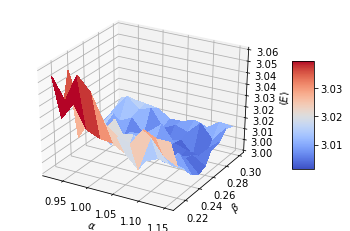

In [20]:
#Here starts the main program with variable declarations
NumberParticles = 2
Dimension = 2
MaxVariations = 10
Energies = np.zeros((MaxVariations,MaxVariations))
Variances = np.zeros((MaxVariations,MaxVariations))
AlphaValues = np.zeros(MaxVariations)
BetaValues = np.zeros(MaxVariations)
(Energies, Variances, AlphaValues, BetaValues) = MonteCarloSampling()
outfile.close()

# Prepare for plots
fig = plt.figure()
ax = fig.gca(projection='3d')
# Plot the surface.
X, Y = np.meshgrid(AlphaValues, BetaValues)
surf = ax.plot_surface(X, Y, Energies,cmap=cm.coolwarm,linewidth=0, antialiased=False)
# Customize the z axis.
zmin = np.matrix(Energies).min()
zmax = np.matrix(Energies).max()
ax.set_zlim(zmin, zmax)
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\beta$')
ax.set_zlabel(r'$\langle E \rangle$')
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
save_fig("QdotMetropolis")
plt.show()